### Import necessary libraries

In [754]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading and Inspection

In [755]:
# Cargar el archivo CSV
df = pd.read_csv('pisos.csv')

# Mostrar las primeras filas para inspeccionar el dataset
df.head()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21984\402079931.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('pisos.csv')


,Unnamed: 0,summary,description,location,photo,recomendado,price,size,rooms,price/m2,bathrooms,Num Photos,type,region
0,0,Casa en calle Urb. Las Mimosas,NaN,Ames (San Tome),https://fotos4.imghs.net/nrd/1069/104/1069_I00...,Recomendado,250.000 €,315 m²,4,793 €/m²,3,31,pisos,a_coruna
1,1,Piso en Milladoiro,NaN,Ames (San Tome),https://fotos4.imghs.net/nrd/1069/113/1069_I00...,Recomendado,90.000 €,72 m²,2,1.250 €/m²,1,11,pisos,a_coruna
2,2,Casa en calle La Piedra,NaN,A Ortigueira (Cariño),https://fotos1.imghs.net/nrd//999170/892070610...,Recomendado,50.000 €,92 m²,2,543 €/m²,1,40,pisos,a_coruna
3,3,Casa en Perillo,NaN,Perillo (Oleiros),https://fotos3.imghs.net/nrd/1089/198/1089_XA2...,Recomendado,359.000 €,244 m²,4,1.471 €/m²,3,39,pisos,a_coruna
4,4,Chalet en Urbanización Las Mimosas,NaN,O Milladoiro (Ames),https://fotos5.imghs.net/nrd/1097/754/1097_0_f...,Recomendado,200.430 €,315 m²,4,636 €/m²,3,24,pisos,a_coruna


### Displaying General Information

In [756]:
# Mostrar información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777179 entries, 0 to 777178
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   777179 non-null  int64 
 1   summary      777179 non-null  object
 2   description  760349 non-null  object
 3   location     776886 non-null  object
 4   photo        776305 non-null  object
 5   recomendado  28241 non-null   object
 6   price        776898 non-null  object
 7   size         776892 non-null  object
 8   rooms        752352 non-null  object
 9   price/m2     744608 non-null  object
 10  bathrooms    752526 non-null  object
 11  Num Photos   776898 non-null  object
 12  type         776898 non-null  object
 13  region       776282 non-null  object
dtypes: int64(1), object(13)
memory usage: 83.0+ MB


### Data Cleaning Process
#### 1) Remove Unnecessary Columns
#### 2) Clean and Convert Price and Size 
#### 3) Inspecting Changes

In [757]:
# Eliminar columnas innecesarias
df.drop(columns=['Unnamed: 0', 'location', 'description', 'photo', 'Num Photos', 'recomendado', 'price/m2', 'summary'], inplace=True)

# Quitar símbolos "€ y m²" en 'price' y 'size' y convertir a numérico
df['price'] = pd.to_numeric(df['price'].str.replace('€', '').str.replace(',', ''), errors='coerce')
df['size'] = pd.to_numeric(df['size'].str.replace('m²', '').str.replace(',', ''), errors='coerce')

# Inspeccionar cambios
df


,price,size,rooms,bathrooms,type,region
0,250.00,315.000,4,3,pisos,a_coruna
1,90.00,72.000,2,1,pisos,a_coruna
2,50.00,92.000,2,1,pisos,a_coruna
3,359.00,244.000,4,3,pisos,a_coruna
4,200.43,315.000,4,3,pisos,a_coruna
...,...,...,...,...,...,...
777174,NaN,4.381,NaN,NaN,fincas_rusticas,valles_oriental_sud
777175,NaN,4.063,NaN,NaN,fincas_rusticas,valles_oriental_sud
777176,NaN,350.000,5,2.0,fincas_rusticas,valles_oriental_sud
777177,456.00,202.000,5,3.0,fincas_rusticas,valles_oriental_sud


###  Handling Missing Values (Remove Rows with Null Values)

In [758]:
# Eliminar filas con valores nulos
df = df.dropna(subset=['price', 'size', 'rooms', 'bathrooms', 'region'])

# Verificar si todavía quedan valores faltantes
print(df.isnull().sum())

price        0
size         0
rooms        0
bathrooms    0
type         0
region       0
dtype: int64


### Converting Columns to Numeric Format

In [759]:
# Convertir las columnas a formato numérico sin usar .loc
df['rooms'] = pd.to_numeric(df['rooms'], errors='coerce')
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['size'] = pd.to_numeric(df['size'], errors='coerce')


C:\Users\Usuario\AppData\Local\Temp\ipykernel_21984\4233683165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rooms'] = pd.to_numeric(df['rooms'], errors='coerce')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21984\4233683165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21984\4233683165.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

### Obtaining Unique Values in the 'type' Column

In [760]:
# Obtener valores únicos en la columna 'type'
unique_types = df['type'].unique()

# Imprimir los valores únicos
print("Valores únicos en 'type':")
print(unique_types)

Valores únicos en 'type':
['pisos' 'casas' 'piso' 'aticos' 'duplexs' 'estudios' 'fincas_rusticas'
 'lofts']


### Replacing 'piso' with 'pisos' in the 'type' Column

In [761]:
# Reemplazar 'piso' por 'pisos' en la columna 'type' sin usar .loc
df['type'] = df['type'].replace('piso', 'pisos')

# Verificar los cambios
print(df['type'].value_counts())


type
pisos              607398
casas               87820
duplexs             12602
aticos              10940
fincas_rusticas      4255
estudios              553
lofts                 419
Name: count, dtype: int64


C:\Users\Usuario\AppData\Local\Temp\ipykernel_21984\1576651671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].replace('piso', 'pisos')


### Removing Outliers from the Dataset

#### To ensure the integrity and reliability of the analysis, we calculated the Interquartile Range (IQR) for the numerical columns in the dataset and filtered out the outliers.

In [762]:
# Calcular los límites para 'size'
Q1_size = df['size'].quantile(0.25)
Q3_size = df['size'].quantile(0.75)
IQR_size = Q3_size - Q1_size
lower_bound_size = Q1_size - 1.5 * IQR_size
upper_bound_size = Q3_size + 1.5 * IQR_size

# Calcular los límites para 'rooms'
Q1_rooms = df['rooms'].quantile(0.25)
Q3_rooms = df['rooms'].quantile(0.75)
IQR_rooms = Q3_rooms - Q1_rooms
lower_bound_rooms = Q1_rooms - 1.5 * IQR_rooms
upper_bound_rooms = Q3_rooms + 1.5 * IQR_rooms

# Calcular los límites para 'bathrooms'
Q1_bathrooms = df['bathrooms'].quantile(0.25)
Q3_bathrooms = df['bathrooms'].quantile(0.75)
IQR_bathrooms = Q3_bathrooms - Q1_bathrooms
lower_bound_bathrooms = Q1_bathrooms - 1.5 * IQR_bathrooms
upper_bound_bathrooms = Q3_bathrooms + 1.5 * IQR_bathrooms

# Calcular los límites para 'price'
Q1_price = df['price'].quantile(0.25)
Q3_price = df['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

# Filtrar el DataFrame para eliminar los outliers de todas las columnas
df_cleaned_final = df[
    (df['size'] >= lower_bound_size) & (df['size'] <= upper_bound_size) &
    (df['rooms'] >= lower_bound_rooms) & (df['rooms'] <= upper_bound_rooms) &
    (df['bathrooms'] >= lower_bound_bathrooms) & (df['bathrooms'] <= upper_bound_bathrooms) &
    (df['price'] >= lower_bound_price) & (df['price'] <= upper_bound_price)
]

df_cleaned_final


,price,size,rooms,bathrooms,type,region
1,90.0,72.0,2,1.0,pisos,a_coruna
2,50.0,92.0,2,1.0,pisos,a_coruna
3,359.0,244.0,4,3.0,pisos,a_coruna
5,320.0,226.0,4,3.0,pisos,a_coruna
6,120.0,196.0,5,2.0,pisos,a_coruna
...,...,...,...,...,...,...
777159,240.0,3.0,3,2.0,duplexs,valles_oriental_sud
777160,247.0,121.0,3,2.0,duplexs,valles_oriental_sud
777161,225.0,5.0,5,3.0,duplexs,valles_oriental_sud
777177,456.0,202.0,5,3.0,fincas_rusticas,valles_oriental_sud


### Size Column Data Cleaning

In our dataset, we identified and addressed issues related to the `size` column, which represents the size of properties in square meters. The following steps were taken to ensure the data's integrity and relevance:

1. **Outlier Removal**: 
   - We calculated the interquartile range (IQR) for the `size` column to identify outliers. 
   - Using the 1.5 * IQR rule, we filtered out properties that had a `size` less than the lower bound or greater than the upper bound.

2. **Minimum Size Check**:
   - Upon further examination, we noticed that there were properties with a size of only 1 square meter, which seemed unusually low. 
   - To establish a more reasonable threshold, we calculated the minimum common size for the dataset, which was determined to be 45 square meters (5th percentile).

3. **Removal of Small Properties**:
   - We counted how many properties had a size less than 45 square meters. 
   - After confirming the number of small properties (1,751 in total), we proceeded to remove these entries from our dataset.

4. **Final Verification**:
   - Post-removal, we verified that no properties remained with a size less than 45 square meters, ensuring the dataset now contains only relevant and appropriately sized properties.

These steps helped us refine the dataset, making it more accurate for subsequent analysis and modeling.


In [763]:
min_common_size = df_cleaned_final['size'].quantile(0.05)  # 5% como ejemplo
print(f"Tamaño mínimo común (5%): {min_common_size}")

Tamaño mínimo común (5%): 45.0


In [764]:
# Resumen estadístico de la columna 'size'
print(df_cleaned_final['size'].describe())


count    626643.000000
mean        108.405955
std          53.553643
min           1.000000
25%          75.000000
50%          96.000000
75%         130.000000
max         283.000000
Name: size, dtype: float64


In [765]:
# Filtrar propiedades con size igual a 1
one_square_meter_properties = df_cleaned_final[df_cleaned_final['size'] == 1]
print(one_square_meter_properties)


        price  size  rooms  bathrooms   type                     region
102      85.0   1.0      1        1.0  pisos                   a_coruna
562     370.0   1.0      4        3.0  pisos                   a_coruna
2829    125.0   1.0      1        1.0  pisos                alava_araba
2993    340.0   1.0      1        1.0  pisos                alava_araba
3922    118.0   1.0      1        1.0  pisos                alava_araba
...       ...   ...    ...        ...    ...                        ...
761908  354.0   1.0      4        3.0  casas     valles_occidental_nord
763998  235.0   1.0      3        2.0  casas      valles_occidental_sud
768988  420.0   1.0      3        2.0  pisos          caldes_de_montbui
772264  420.0   1.0      3        2.0  casas            valles_oriental
775161  420.0   1.0      3        2.0  casas  valles_oriental_nord_oest

[1751 rows x 6 columns]


In [766]:
min_common_size = df_cleaned_final['size'].quantile(0.05)  # 5% como ejemplo
print(f"Tamaño mínimo común (5%): {min_common_size}")

Tamaño mínimo común (5%): 45.0


In [767]:
# Contar cuántas viviendas tienen un tamaño menor al tamaño mínimo común
num_small_properties = df_cleaned_final[df_cleaned_final['size'] < 45.0].shape[0]
print(f"Número de viviendas con tamaño menor a 45.0 m²: {num_small_properties}")


Número de viviendas con tamaño menor a 45.0 m²: 30361


In [768]:
# Eliminar viviendas con tamaño menor a 45.0 m²
df_cleaned_final = df_cleaned_final[df_cleaned_final['size'] >= 45.0]

# Contar cuántas viviendas quedan después de la eliminación
num_remaining_properties = df_cleaned_final.shape[0]
print(f"Número de viviendas restantes después de eliminar las pequeñas: {num_remaining_properties}")


Número de viviendas restantes después de eliminar las pequeñas: 596282


### Steps to Ensure the Integrity of the `price` Column

1. **Outlier Removal**:
   - We calculated the interquartile range (IQR) for the `price` column to identify outliers.
   - Using the 1.5 * IQR rule, we filtered out properties with prices below the lower bound or above the upper bound, thereby removing anomalous prices.

2. **Minimum Price Check**:
   - Upon further examination, we noticed properties with extremely low prices, such as 7.500 euros, which seemed unusual.
   - To establish a more reasonable threshold, we calculated the minimum common price for the dataset (the 5th percentile of prices).

3. **Removal of Low-Priced Properties**:
   - After confirming the number of low-priced properties, we proceeded to remove these entries from our dataset.

4. **Final Verification**:
   - Post-removal, ensuring that the dataset now contains only relevant and appropriately priced properties.

These steps helped us refine the dataset, making it more accurate for subsequent analysis and modeling.


In [769]:
# Obtener estadísticas descriptivas para 'price'
price_description = df_cleaned_final['price'].describe()
print(price_description)


count    596282.000000
mean        159.076820
std          96.453586
min           7.500000
25%          85.000000
50%         136.000000
75%         209.900000
max         490.000000
Name: price, dtype: float64


In [770]:
# Calcular el percentil 5 de precios por tipo de propiedad
min_price_common = df_cleaned_final.groupby('type')['price'].quantile(0.05)
print(min_price_common)


type
aticos             76.000
casas              48.000
duplexs            75.652
estudios           46.000
fincas_rusticas    39.480
lofts              67.650
pisos              44.000
Name: price, dtype: float64


In [771]:
# Definir los precios mínimos comunes para cada tipo de propiedad
min_prices = {
    'aticos': 76.0,
    'casas': 48.0,
    'duplexs': 75.652,
    'estudios': 46.0,
    'fincas_rusticas': 39.480,
    'lofts': 67.650,
    'pisos': 44.0
}
# Filtrar propiedades con precios por debajo del mínimo común
df_below_min_price = df_cleaned_final[df_cleaned_final.apply(
    lambda row: row['price'] < min_prices.get(row['type'], float('inf')), axis=1)]

# Mostrar las propiedades con precios bajos
df_below_min_price


,price,size,rooms,bathrooms,type,region
69,31.5,69.0,3,1.0,pisos,a_coruna
277,43.5,87.0,3,2.0,pisos,a_coruna
292,30.0,110.0,3,2.0,pisos,a_coruna
345,43.7,51.0,2,1.0,pisos,a_coruna
358,43.0,84.0,1,1.0,pisos,a_coruna
...,...,...,...,...,...,...
770689,41.8,58.0,2,1.0,pisos,montornes_del_valles
773417,41.8,58.0,2,1.0,pisos,valles_oriental
773743,41.8,58.0,2,1.0,pisos,valles_oriental
776599,41.8,58.0,2,1.0,pisos,valles_oriental_sud


In [772]:
# Eliminar propiedades con precios por debajo del mínimo común
df_cleaned_final = df_cleaned_final[df_cleaned_final.apply(
    lambda row: row['price'] >= min_prices.get(row['type'], float('inf')), axis=1)]


In [773]:
df_cleaned_final.shape

(566947, 6)

### Media y Mediana de Precio por Tipo de Propiedad

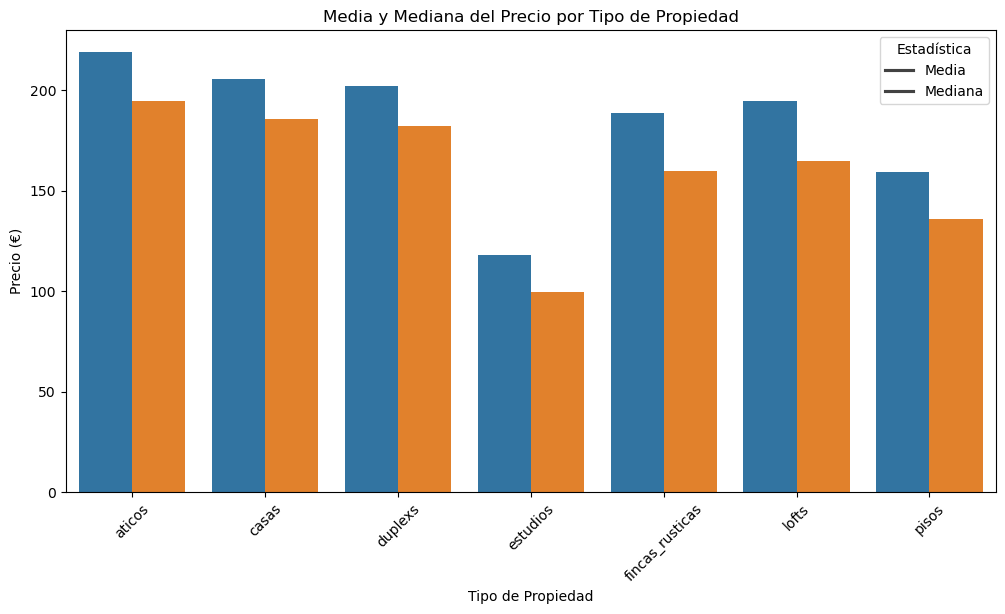

In [774]:


# Calcular la media y la mediana del precio por tipo de propiedad
price_stats = df_cleaned_final.groupby('type')['price'].agg(['mean', 'median']).reset_index()

# Crear un gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=price_stats.melt(id_vars='type'), x='type', y='value', hue='variable')
plt.title('Media y Mediana del Precio por Tipo de Propiedad')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('Precio (€)')
plt.xticks(rotation=45)
plt.legend(title='Estadística', labels=['Media', 'Mediana'])
plt.show()


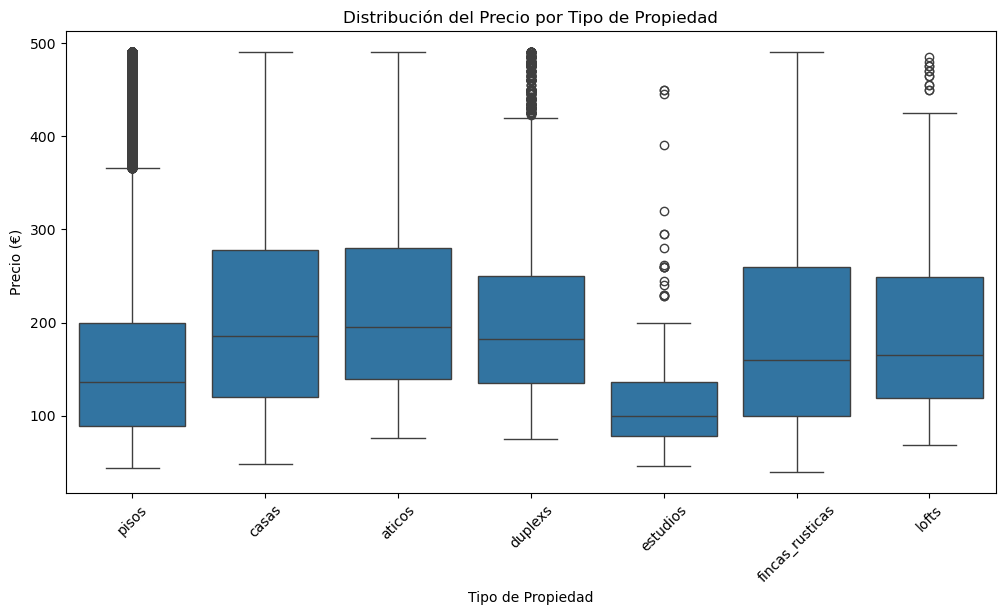

In [775]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned_final, x='type', y='price')
plt.title('Distribución del Precio por Tipo de Propiedad')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('Precio (€)')
plt.xticks(rotation=45)
plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_21984\3314408954.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=type_counts_df, x='Cantidad', y='Tipo de Propiedad', palette='viridis')


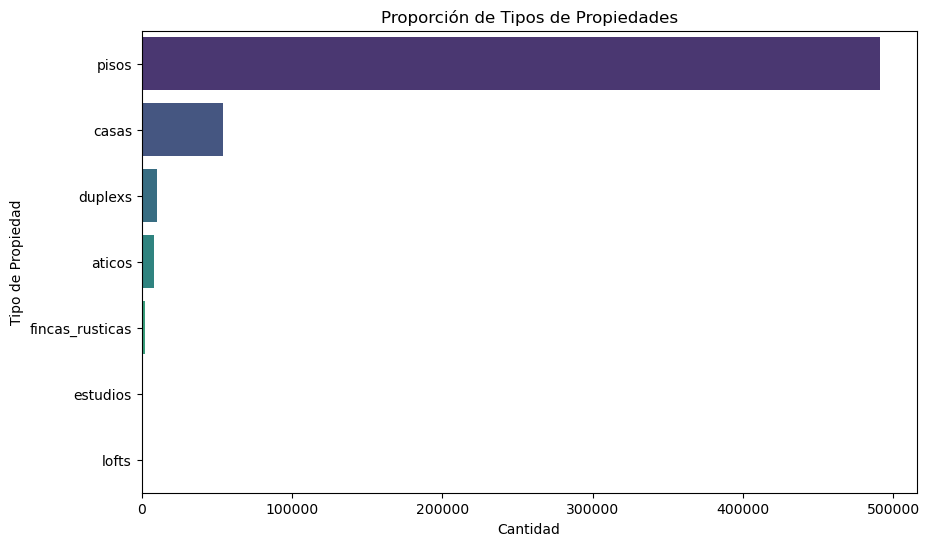

In [776]:
# Calcular el conteo de cada tipo de propiedad
type_counts = df_cleaned_final['type'].value_counts()

# Crear un DataFrame para facilitar la visualización
type_counts_df = type_counts.reset_index()
type_counts_df.columns = ['Tipo de Propiedad', 'Cantidad']

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=type_counts_df, x='Cantidad', y='Tipo de Propiedad', palette='viridis')
plt.title('Proporción de Tipos de Propiedades')
plt.xlabel('Cantidad')
plt.ylabel('Tipo de Propiedad')
plt.show()


### The correlation matrix (shows the correlation between various numerical features).

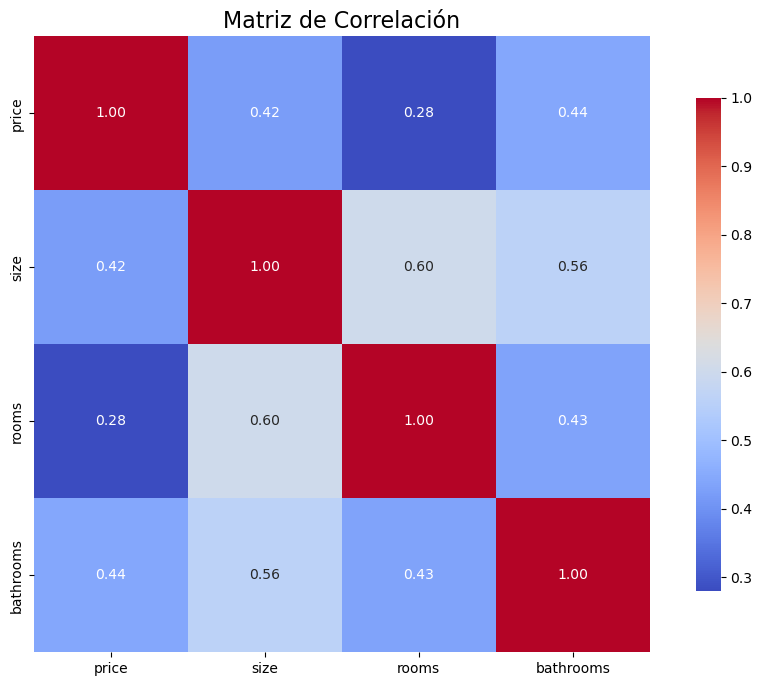

In [777]:
# Filtrar solo columnas numéricas
numeric_df = df_cleaned_final.select_dtypes(include='number')

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 8))

# Crear un mapa de calor
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8})

# Añadir un título
plt.title('Matriz de Correlación', fontsize=16)
plt.show()


### Perform Train Test Split

### Linear Regression Model for Price Prediction

#### In this section, we defined the features and target variable, preprocessed the data, trained a linear regression model, and evaluated its performance.

In [778]:
# Definir características (features) y variable objetivo (target)
X = df_cleaned_final[['size', 'rooms', 'bathrooms', 'type', 'region']]
y = df_cleaned_final['price']  # La variable objetivo

# Preprocesar características categóricas y escalar numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['size', 'rooms', 'bathrooms']),  # Escalar columnas numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['type', 'region'])  # One-Hot-Encoding para columnas categóricas
    ],
    remainder='passthrough'  # No eliminar otras columnas si las hay
)

# Crear un pipeline que primero preprocesa y luego ajusta el modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar el modelo a los datos de entrenamiento
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"R² score del modelo en el conjunto de prueba: {r2:.4f}")


Error cuadrático medio (MSE): 4249.23
R² score del modelo en el conjunto de prueba: 0.5251


In [779]:
from sklearn.metrics import mean_absolute_error

# Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # RMSE es simplemente la raíz cuadrada del MSE
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"Error absoluto medio (MAE): {mae:.2f}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse:.2f}")
print(f"R² score del modelo en el conjunto de prueba: {r2:.4f}")


Error cuadrático medio (MSE): 4249.23
Error absoluto medio (MAE): 48.86
Raíz del error cuadrático medio (RMSE): 65.19
R² score del modelo en el conjunto de prueba: 0.5251


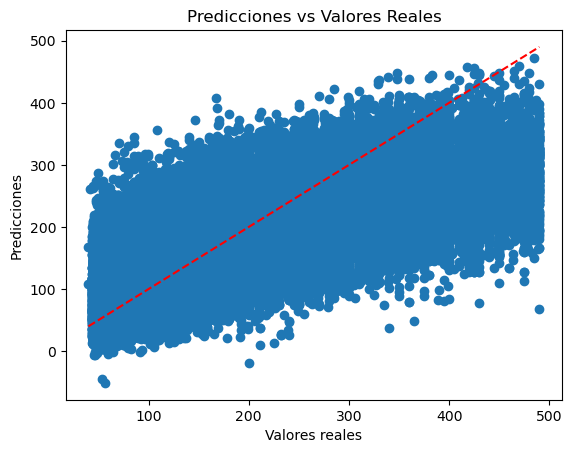

In [780]:
import matplotlib.pyplot as plt

# Gráfica de predicciones vs valores reales
plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea de referencia
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Suponiendo que tienes tu DataFrame llamado df
X = df.drop('price', axis=1)  # Las características
y = df['price']  # La variable objetivo

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un transformador para las variables categóricas
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['type', 'region'])  # Codificar 'type' y 'region'
    ],
    remainder='passthrough'  # Mantener las otras columnas sin cambios
)

# Crear un pipeline con el transformador y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Ajustar el modelo a los datos de entrenamiento
pipeline.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rf = pipeline.predict(X_test)

# Calcular errores
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_rf)

print(f"Error cuadrático medio (MSE): {mse:.2f}")
print(f"Error absoluto medio (MAE): {mae:.2f}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse:.2f}")
print(f"R² score del modelo en el conjunto de prueba: {r2:.4f}")
